In [14]:
import logging
import os
import pdb
import time
import warnings
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import xarray
from tqdm import tqdm

import G211
from lightning import ztfs

%matplotlib inline
from ml_functions import get_args, get_features, get_flash_pred, predct2
from spc import get_issuance_time
from statisticplot import stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

In [15]:
# %load_ext autoreload
# %autoreload 2

In [16]:
# map projection
map_crs = G211.g211
grid = G211.grid
grid = grid.to_crs(ccrs.PlateCarree())

conus_mask = G211.mask

### Load SPC enhanced tstm outlook

In [17]:
# downloaded by get_enhtstm.ipynb
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
column = "DN"

sfiles[0].name, sfiles[-1].name, len(sfiles)

('enh00_20200101_012000_202001010525-shp.zip',
 'enh20_20230630_301600_202306301252-shp.zip',
 15425)

In [18]:
obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"

f = f"{obsvar}_{rptdist}km_{twin}hr"
# Define observation/probability thresholds
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")
pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0
args = get_args(o_thresh, twin)
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2020-12-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [19]:
def spc_forecast_obs(sfile: str):
    """
    get forecast valid start and end from sfile string
    return (forecast, observations) tuple from same period
    """

    assert twin > 1, "no DNN time windows for twin == 1"

    f = geopandas.read_file(sfile).to_crs(ccrs.PlateCarree())
    record = os.path.basename(sfile)

    issue, valid_start, valid_end = get_issuance_time(record)
    logging.info(f"{issue} {valid_start} {valid_end}")

    # Get observations from DataFrame from ml_functions.load_df()
    # instead of lightning.get_obs()
    # so you have the same data, and don't "repeat" the same
    # function with different code.
    # get_obs allows GLM or WxBug to be missing for a time
    # but load_df does not.

    # Uses `obs` DataFrame already sliced from Y DataFrame outside function.

    valid_times = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    # if all expected valid_times are available
    if all(
        [
            valid_time in obs.index.get_level_values("valid_time")
            for valid_time in valid_times
        ]
    ):
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            # reduce initialization_time dimension for multiple
            # initialization_times that have the same valid_time.
            # obs is the same for each init time so just
            # take the first.
            o = (
                obs.loc[
                    (slice(None), slice(None), slice(None), valid_times),
                    args.labels,
                ]
                .groupby(["x", "y", "valid_time"])
                .first()
            )
        o = o.groupby(["x", "y"]).sum()  # sum valid times
    else:
        return None

    # Assign value to conus grid points within polygons
    f = grid[conus_mask.values.ravel()].sjoin(f, how="left")

    f["record"] = record
    f["issue"] = issue
    # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
    # when saving to parquet
    f["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
    f["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
    columns = ["record", "DN", "issue", "valid_start", "valid_end"]
    # fill missing fcst prob (outside any polygon) with 0. Join with obs.
    f = f[columns].fillna(0).join(o)
    f = f.set_index("record", append=True)

    return f

### Load DataFrame of DNN forecasts / observations

In [20]:
# get observations from DNN forecast/obs DataFrame
Y = get_flash_pred(args, clobber=clobber)

# ensmean of fits and folds
# Don't be clever by subtracting {"fit", "fold"} set from Y.index.names
# Order of returned list of levels was random. valid_time did not always come 2nd.
levels = ["initialization_time", "valid_time", "y", "x", "forecast_hour", "lat", "lon"]
logging.warning(f"groupby {levels} for ensmean")
ensmean = Y.groupby(level=levels).mean()

# obs used in spc_forecast_obs() defined above
logging.warning("obs (label) slice")
obs = ensmean.xs("y_label", axis="columns", level=0)

2024-02-09 08:38:02,325 Create /glade/derecho/scratch/ahijevyc/tmp/HRRR.4hr.par from 736 HRRR files.
/glade/work/ahijevyc/NSC_objects/notebooks/G211.py:63: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path("naturalearth_lowres")
/glade/work/ahijevyc/NSC_objects/notebooks/G211.py:63: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path("naturalearth_lowres")
/glade/work/ahijevyc/conda-envs/tf/lib/python3.11/site-packages/xarray/core/dataset.py:5196: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.

2414/2414 [==============================] - 523s 216ms/step


2024-02-09 09:55:19,122 (0, 2) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_2/1fold0


 569/2414 [======>.......................] - ETA: 8:09

2024-02-09 10:04:29,677 (0, 3) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_3/1fold0


1538/2414 [==================>...........] - ETA: 1:59

2024-02-09 10:15:37,655 (0, 4) /glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr_4/1fold0


2414/2414 [==============================] - 136s 56ms/step


2024-02-09 10:23:40,082 groupby ['initialization_time', 'valid_time', 'y', 'x', 'forecast_hour', 'lat', 'lon'] for ensmean
2024-02-09 10:24:23,710 obs (label) slice


## Verify SPC enhanced tstm forecast

### Match obs to each SPC forecast in parallel

In [21]:
ffile = tmpdir / f"spc_fcst.{twin}hr.par"

if not clobber and os.path.exists(ffile):  # and os.path.exists(ofile):
    logging.warning(f"read {ffile} {os.path.getsize(ffile)/1e6:.1f}M ")
    spc_fcst = pd.read_parquet(ffile)
else:
    logging.warning(f"make new file {ffile}")
    if twin == 2:
        logging.warning("Sure u want to compare DNNs with 2-hour time window to SPC?")

    assert obs.cg_40km_4hr.sum() > 0, (
        "no lightning obs. did you run cells further down that changed"
        " obs and then come back"
        " to this cell?"
    )

    # Use multiple cpus (like 16) and 60+GB memory.
    # 16 cpu, 89 GB, 16 processes took 17 minutes (twin=4)
    with Pool(processes=20) as pool:
        result = pool.map(
            spc_forecast_obs,
            tqdm(sfiles),
        )

    spc_fcst = pd.concat([x for x in result if x is not None])
    spc_fcst.to_parquet(ffile)

# tried saving this to parquet ofile but tuple in column broke arrow engine
spc_fcst["prodid"] = list(
    zip(
        spc_fcst.issue,
        pd.to_datetime(spc_fcst.valid_start).dt.hour,
        pd.to_datetime(spc_fcst.valid_end).dt.hour,
    )
)

logging.info("trim spc_fcst to testing range of neural network")
before_trim = len(spc_fcst)
spc_fcst = spc_fcst[
    (pd.to_datetime(spc_fcst.valid_start) >= pd.to_datetime(args.teststart))
    & (pd.to_datetime(spc_fcst.valid_end) <= pd.to_datetime(args.testend))
]
logging.warning(
    f"kept {len(spc_fcst)}/{before_trim} ({len(spc_fcst)/before_trim:%}) spc fcsts"
)

assert "enh00_20211231_312000_202112310559-shp.zip" in spc_fcst.index.get_level_values(
    "record"
)

2024-02-09 13:14:17,423 read /glade/derecho/scratch/ahijevyc/tmp/spc_fcst.4hr.par 4.1M 
2024-02-09 13:14:43,439 kept 6058656/6058656 (100.000000%) spc fcsts


1167.0
[('1300', 0, 4) ('1700', 0, 4) ('2100', 0, 4)] [380 389 398] 0.2222
1152.0
[('0130', 4, 12) ('1700', 4, 12) ('2100', 4, 12)] [381 374 397] 0.2063
383.0
[('0600', 12, 16)] [383] 0.1094
769.0
[('0600', 16, 20) ('1300', 16, 20)] [357 412] 0.1533
1161.0
[('0600', 20, 0) ('1300', 20, 0) ('1700', 20, 0)] [362 403 396] 0.2961


2024-02-09 13:15:20,906 /glade/derecho/scratch/ahijevyc/tmp/enhtstm.001+cg.ic_20km.png


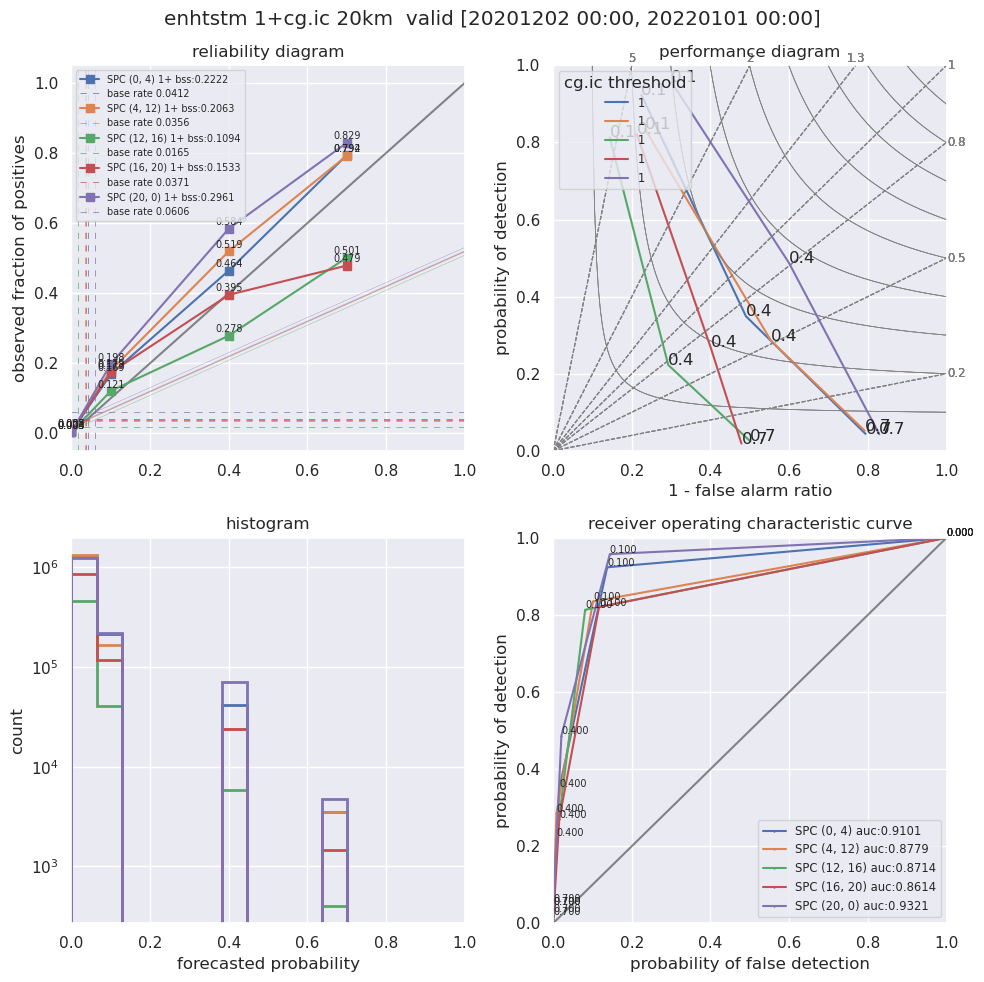

In [22]:
def valid_hour_str(prodids):
    valid_hour_range = prodids[0][1:]  # last 2 elements of first prodids tuple
    same_valid_hour_range = len(set([x[1:] for x in prodids])) == 1
    if same_valid_hour_range:
        return " " + str(valid_hour_range)
    return ""


fcst = spc_fcst
fcst = fcst.DN / 100

prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20)],
    [("0600", 20, 0)],
]

# Aggregate by valid time
prodidss = [
    [("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4)],
    [("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12)],
    [("0600", 12, 16)],
    [("0600", 16, 20), ("1300", 16, 20)],
    [("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0)],
]

# Flatten list of lists to get every issuance and valid time in its own list
# prodidss = [[x] for prodid in prodidss for x in prodid]
# All together
# prodidss = [[x for prodid in prodidss for x in prodid]]

ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))
title = ""
for prodids in prodidss:
    logging.info(f"forecast products for {len(prodids)} prodids")
    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    print(ihr.sum() / 1308)

    # 1308 CONUS points per forecast
    cnt = (spc_fcst[ihr].groupby("prodid").size() / 1308).astype(int)

    print(cnt.index.values, cnt.values, end=" ")
    title += "  ".join([f"{c}{v}" for c, v in list(zip(cnt, cnt.index))])

    thisf = fcst[ihr]
    thisf.name = "SPC" + valid_hour_str(prodids)

    fig = stat_plots(
        spc_fcst.loc[ihr, f],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh=o_thresh,
        sep=0.01,
        n_bins=11,
        fig=fig,
    )

title = f"enhtstm {o_thresh}+{obsvar} {rptdist}km"
title += f"  valid [{spc_fcst.valid_start.min()}, {spc_fcst.valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()
ofile = tmpdir / f"enhtstm.{o_thresh:03d}+{obsvar}_{rptdist}km.png"
plt.savefig(ofile)
logging.warning(ofile)

/glade/derecho/scratch/ahijevyc/tmp/cnt.png


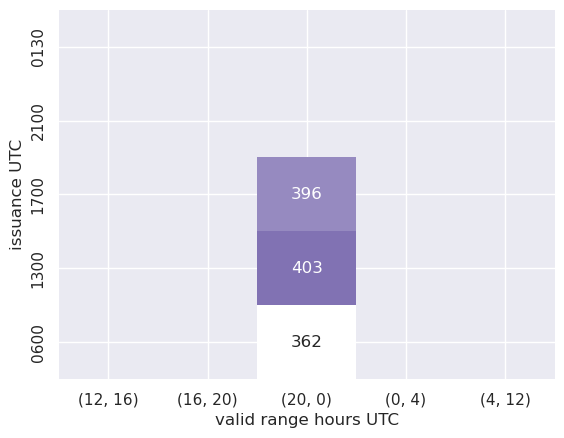

In [23]:
def plot_cnt(cnt, cmap=None):
    df = pd.DataFrame(
        cnt.index.tolist(),
        columns=["issuance UTC", "valid_start_hour", "valid_end_hour"],
    )
    df["valid range hours UTC"] = list(zip(df.valid_start_hour, df.valid_end_hour))
    df["n"] = cnt.values
    df = df.reset_index().pivot(
        columns="valid range hours UTC", index="issuance UTC", values="n"
    )
    df = df.reindex(
        ["0130", "2100", "1700", "1300", "0600"],
        columns=[(12, 16), (16, 20), (20, 0), (0, 4), (4, 12)],
    )
    g = sns.heatmap(df, annot=True, fmt="3.0f", cmap=cmap, cbar=False)
    return g


g = plot_cnt(
    cnt,
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "cnt", ["white", fig.get_axes()[0].get_lines()[-1].get_color()]
    ),
)
ofile = tmpdir / "cnt.png"
plt.savefig(ofile)
print(ofile)

## Verify dense neural network forecast

In [24]:
ensmean.index.get_level_values("forecast_hour").unique()

Index([48, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='forecast_hour')

## Get obsvar at rptdist and twin from DNN obs and fcst
### Plot DNN performance at all valid times, regardless of SPC fcst

In [25]:
import sklearn
from shapely.geometry import Polygon

from ml_functions import brier_skill_score


def statjob(group):
    logging.info(f"statjob: {group.name}")
    # seperate y_pred and labels and drop level 0
    y_pred = group.xs("y_pred", axis="columns", level=0)
    # labels went from bool to object dtype, so fix it or roc_auc_score will not recognize format
    labels = group.xs("y_label", axis="columns", level=0).astype(bool)

    bss = brier_skill_score(labels, y_pred)
    base_rate = labels.mean()
    # Default value is np.nan
    # Don't assign Series to auc and aps on same line or they will remain equal even if you change one
    auc = pd.Series(np.nan, index=labels.columns)
    aps = pd.Series(np.nan, index=labels.columns)
    # auc and aps require 2 unique labels, i.e. both True and False
    two = labels.nunique() == 2
    if two.any():
        # average=None returns a metric for each label instead of one group average of all labels
        auc[two] = sklearn.metrics.roc_auc_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
        aps[two] = sklearn.metrics.average_precision_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
    n = y_pred.count()
    # geometry for geopandas dataframe
    forecast_hour, lat_bin, lon_bin = group.name
    poly = Polygon(
        (
            (lon_bin.left, lat_bin.left),
            (lon_bin.left, lat_bin.right),
            (lon_bin.right, lat_bin.right),
            (lon_bin.right, lat_bin.left),
        )
    )

    out = pd.DataFrame(
        dict(
            bss=bss,
            base_rate=base_rate,
            auc=auc,
            aps=aps,
            n=n,
            geometry=poly,
            forecast_hour=0.5 * (forecast_hour.left + forecast_hour.right),
        )
    )
    out.index.name = "class"
    return out

In [26]:
tqdm.pandas()
fhr_bin = pd.cut(ensmean.index.get_level_values("forecast_hour"), bins=range(0, 49, 1))
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=np.arange(25, 50, 2))
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=np.arange(-126, -64, 2))

by_llfhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
).progress_apply(statjob)

by_llfhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

/glade/derecho/scratch/ahijevyc/tmp/ipykernel_33448/2053903951.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_llfhr = ensmean.groupby(
100%|██████████| 11280/11280 [10:30<00:00, 17.90it/s]


In [27]:
import folium.plugins

m = folium.plugins.DualMap(location=[37, -95], zoom_start=3, layout="vertical")

s = fhr_bin.categories[8]  # pick a forecast hour bin
print(s)
gdf = geopandas.GeoDataFrame(
    by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
)
gdf.explore(
    column="bss",
    vmin=0.0,
    vmax=0.6,
    style_kwds={"fillOpacity": 0.8},
    cmap="Greens",
    m=m.m1,
)
gdf.explore(
    column="base_rate",
    vmin=0,
    vmax=0.05 * twin,
    style_kwds={"fillOpacity": 0.8},
    cmap="Purples",
    m=m.m2,
)

(8, 9]


In [28]:
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=1)
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=1)
by_fhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
).progress_apply(statjob)

by_fhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

/glade/derecho/scratch/ahijevyc/tmp/ipykernel_33448/2742356265.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_fhr = ensmean.groupby(
100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


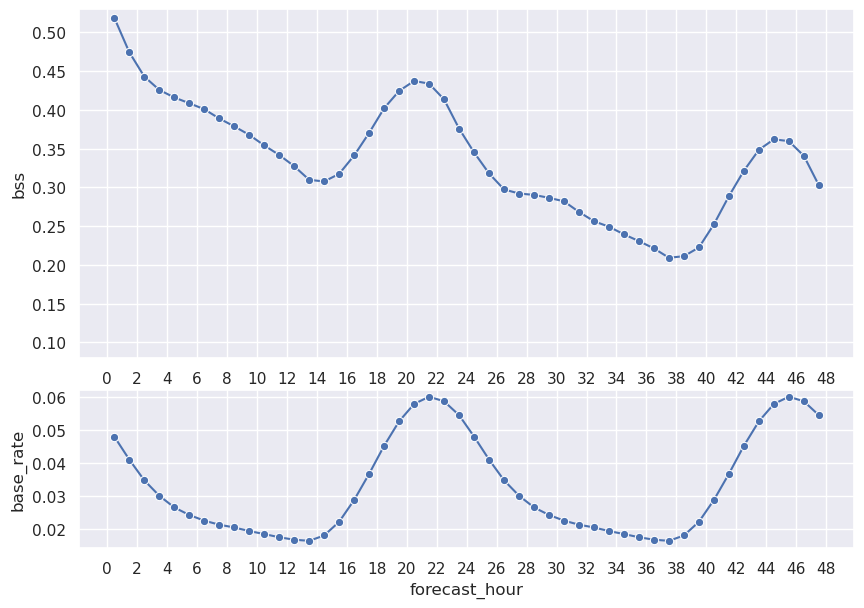

In [29]:
# Figure dimensions
fig = plt.figure(figsize=(10, 7))

topax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
botax = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=topax)
botax.xaxis.set_major_locator(ticker.MultipleLocator(2))

ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="bss",
    ax=topax,
    marker="o",
)
ax.set_ylim((0.08, 0.53))
ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="base_rate",
    ax=botax,
    marker="o",
    legend=False,
)

In [30]:
fcst.index

MultiIndex([(12, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 49, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 69, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 70, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 47, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 69, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 70, 'enh00_20201202_022000_202012020531-shp.zip'),
            (14, 47, 'enh00_20201202_022000_202012020531-shp.zip'),
            (14, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            ...
            (45, 33, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 34, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 35, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 36, 'enh20_20211231_311600_202112311237-shp.zip'),
            (46, 23, 'enh20_2021

0.3581


2024-02-09 13:30:15,679 made /glade/work/ahijevyc/NSC_objects/notebooks/dnn.001+cg.ic.all.initialization_time.valid_time.y.x.forecast_hour.lat.lon.png


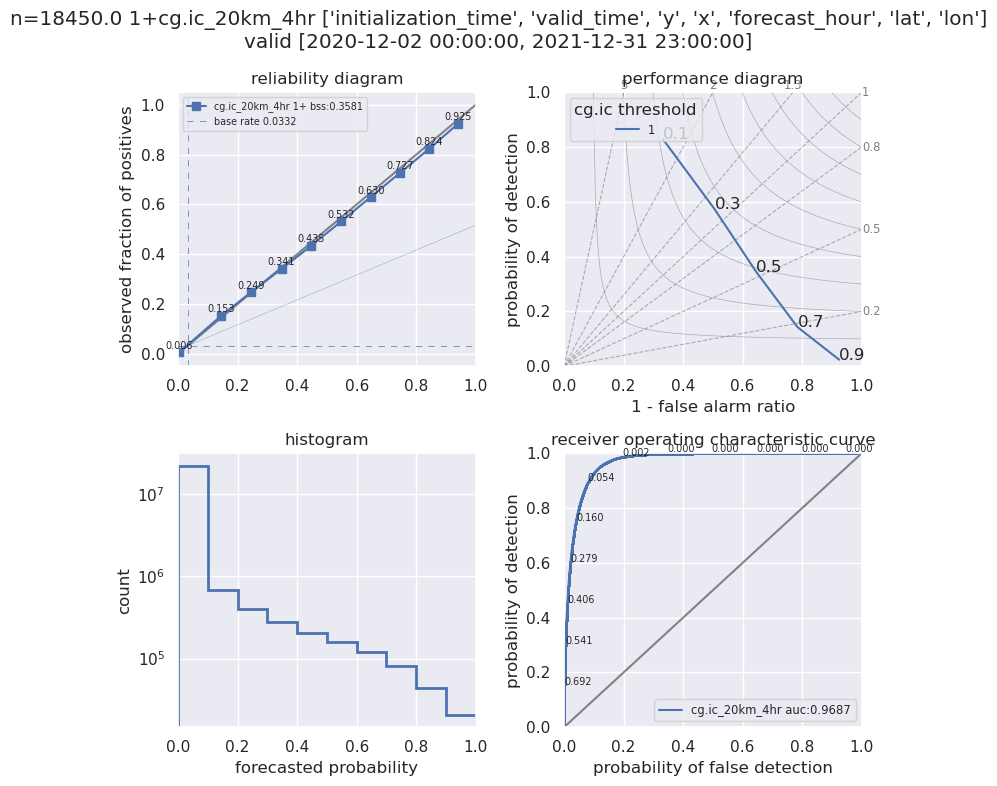

In [31]:
obs = ensmean.xs("y_label", axis="columns", level=0)
fcst = ensmean.xs("y_pred", axis="columns", level=0)
pthresh = pd.Series(np.round(np.arange(0.1, 1.1, 0.2), 2), name=f"fcst\np thresh")

valid_range_str = (
    f'[{ensmean.index.get_level_values("valid_time").min()},'
    f' {ensmean.index.get_level_values("valid_time").max()}]'
)

_ = stat_plots(
    obs[f],
    fcst[f],
    thresh=thresh,
    pthresh=pthresh,
    o_thresh=o_thresh,
    sep=0.15,
    suptitle=f"n={len(ensmean)/1308} {o_thresh}+{f} {levels}\nvalid {valid_range_str}",
)
ofile = f"dnn.{o_thresh:03d}+{obsvar}.all.{'.'.join(levels)}.png"
ofile = tmpdir / os.path.realpath(ofile)
plt.savefig(ofile)
logging.warning(f"made {ofile}")

## Restrict DNN to valid times of SPC forecast

In [32]:
def pprod(record, fcst=fcst):
    """
    Return DNN probability for the same valid range as
    an spc forecast record.
    Valid range may span consecutive time windows, each
    with an independent DNN probability.
    """
    s = record.name
    issue, valid_start, valid_end = get_issuance_time(s)
    dnntimes = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    assert fcst.index.names[1] == "valid_time", "valid_time must be MultiIndex level 1"
    try:
        thisfcst = fcst.loc[(slice(None), dnntimes), :]
        # Probability of no occurences during multiple time windows
        # equals product of 1-p for each time window.
        prob_none = (1 - thisfcst).groupby(["y", "x"]).prod()
        # Probability of one or more occurrences is 1 minus that.
        p = 1 - prob_none
        return p
    except KeyError as err:
        logging.warning(f"{err} {s} {issue} [{valid_start},{valid_end}]")
    except:
        logging.error(f"pprod broke on {s} {issue} [{valid_start},{valid_end}]")
        sys.exit(1)


fhr_start = int(12 + twin / 2)
fhr_end = int(36 - twin / 2)
logging.warning(
    f"Limit forecast hour range [{fhr_start}, {fhr_end}], get ensemble mean"
)
# selected forecast hours only. drops level by default
fcst = fcst.xs(slice(fhr_start, fhr_end), level="forecast_hour")

pprod_par = tmpdir / f"ps.fhr{fhr_start}-{fhr_end}.{o_thresh:03d}+{platform}.par"
if not clobber and os.path.exists(pprod_par):
    logging.warning(f"use old dnn probability product output {pprod_par}")
    p = pd.read_parquet(pprod_par)
else:
    time0 = time.time()
    logging.warning(
        f"Save dnn probability for each spc forecast (i.e. record) to {pprod_par}"
    )
    tqdm.pandas()
    p = spc_fcst.groupby("record").progress_apply(pprod, fcst=fcst)
    p.to_parquet(pprod_par)
    print(time.time() - time0)

logging.warning(
    "get (issuance time, valid hours) from DNN forecasts matched to SPC records"
)
x = [get_issuance_time(s) for s in tqdm(p.index.get_level_values("record"))]
issue, valid_start, valid_end = map(np.array, zip(*x))

valid_start_hours = np.array([x.hour for x in valid_start])
valid_end_hours = np.array([x.hour for x in valid_end])

2024-02-09 13:30:17,862 Limit forecast hour range [14, 34], get ensemble mean
2024-02-09 13:30:19,566 use old dnn probability product output /glade/derecho/scratch/ahijevyc/tmp/ps.fhr14-34.001+wbug.par
2024-02-09 13:30:23,594 get (issuance time, valid hours) from DNN forecasts matched to SPC records
100%|██████████| 6058656/6058656 [03:45<00:00, 26811.52it/s]


## get obs at DNN times
### verify, plot, overlay on SPC scores

n=1167 1+cg.ic_20km_4hr [('1300', 0, 4), ('1700', 0, 4), ('2100', 0, 4)] 0.2944
n=1152 1+cg.ic_20km_4hr [('1700', 4, 12), ('2100', 4, 12), ('0130', 4, 12)] 0.3125
n=383 1+cg.ic_20km_4hr [('0600', 12, 16)] 0.2882
n=769 1+cg.ic_20km_4hr [('0600', 16, 20), ('1300', 16, 20)] 0.3497
n=1161 1+cg.ic_20km_4hr [('0600', 20, 0), ('1300', 20, 0), ('1700', 20, 0)] 0.4140


2024-02-09 13:38:57,167 made /glade/derecho/scratch/ahijevyc/tmp/dnn.001+cg.ic_20km_4hr.png


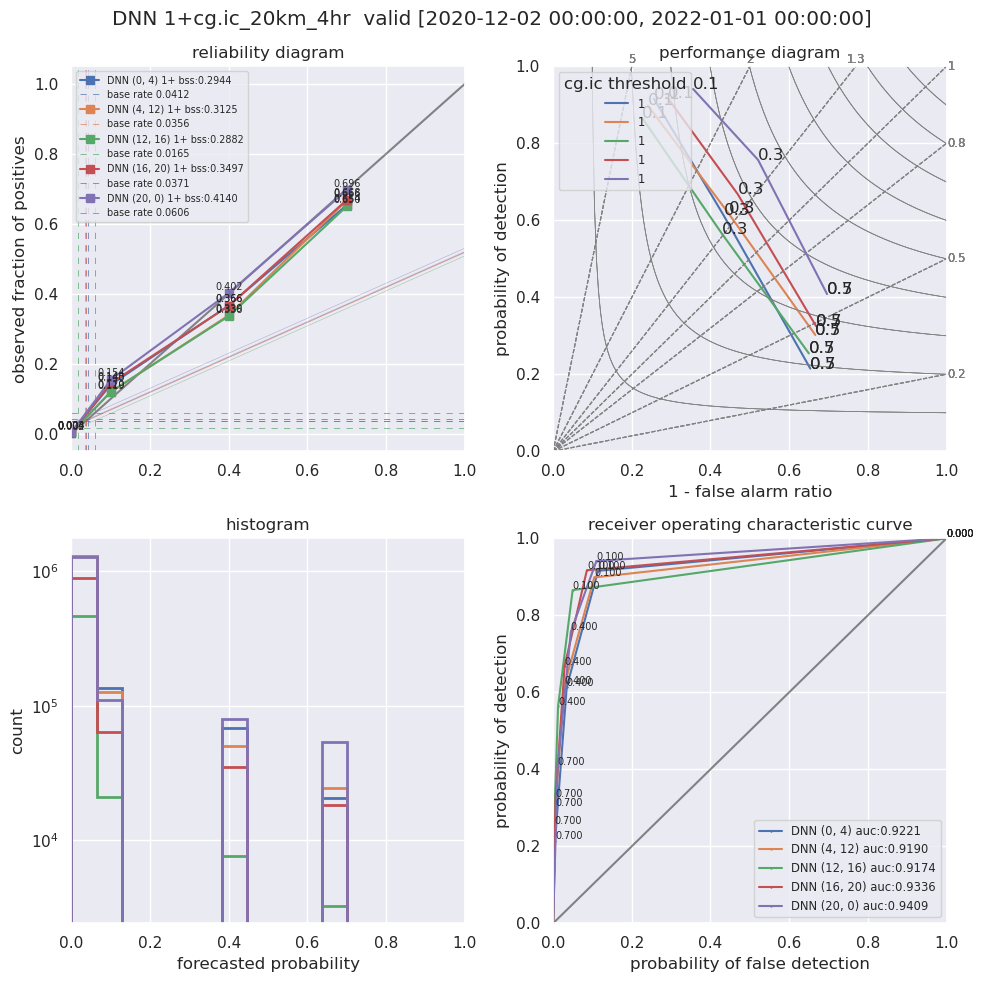

In [33]:
def ztfs(x, how="nearest"):
    """
    zero, ten, forty, seventy
    If how="floor", round x DOWN to nearest probability level of
    SPC Thunderstorm Outlook.
    If how="nearest", round x to nearest (down OR up).
    """
    assert x >= 0
    assert x <= 1
    if how == "floor":
        if x < 0.1:
            return 0
        if x < 0.4:
            return 0.1
        if x < 0.7:
            return 0.4
        return 0.7
    if how == "nearest":
        if x < 0.05:
            return 0
        if x < 0.25:
            return 0.1
        if x < 0.55:
            return 0.4
        return 0.7


obs = spc_fcst.reorder_levels(p.index.names).loc[p.index, f]
# fcst = p.xs("y_pred", axis="columns", level=0)[f] # TODO: why did i ever have to take cross section of p?
fcst = p[f]
fcst = fcst.map(ztfs)  # round down DNN probs to limited SPC prob levels

keep_SPC_fig = False
if not keep_SPC_fig:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))

for prodids in prodidss:
    iprodid = (
        pd.Series(list(zip(issue, valid_start_hours, valid_end_hours)))
        .isin(prodids)
        .values
    )
    print(f"n={iprodid.sum()/1308:.0f} {o_thresh}+{f} {prodids}", end=" ")

    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    # DNN forecasts are missing when obsvar is missing in twin-h time window.
    # However there may be valid obsvar within longer valid time window of SPC forecast.
    # get_obs allows for missing obsvar. It just takes the mean of what is
    # available and then multiplies it by the total time window length.
    # e.g. you get a valid lightning count from get_obs(pd.to_datetime("20210827T20"), pd.to_datetime("20210828T00"), obsvar, 2, rptdist)
    # but labels is missing for one of the 2-h components of that 4-hour SPC forecast valid time window.
    # labels.loc[("2021-08-27", "2021-08-27 21:00:00", 12, 48, slice(None))]
    missing_DNN_forecasts = set(spc_fcst[ihr].groupby("record").first().index) - set(
        p[iprodid].groupby("record").first().index
    )
    if len(missing_DNN_forecasts):
        logging.warning(f"{len(missing_DNN_forecasts)} missing DNN forecasts")
        print(missing_DNN_forecasts)

    missing_SPC_forecasts = set(p[iprodid].groupby("record").first().index) - set(
        spc_fcst[ihr].groupby("record").first().index
    )
    if len(missing_SPC_forecasts):
        logging.warning(f"{len(missing_SPC_forecasts)} missing SPC forecasts")
        print(missing_SPC_forecasts)

    thisf = fcst[iprodid]
    thisf.name = "DNN" + valid_hour_str(prodids)

    fig = stat_plots(
        obs[iprodid],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh=o_thresh,
        sep=0.15,
        n_bins=11,
        fig=fig,
    )
title = f"DNN {o_thresh}+{f}  valid [{valid_start.min()}, {valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()

ofile = tmpdir / f"dnn.{o_thresh:03d}+{f}.png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")

In [34]:
products = ["SPC", "DNN"]
issuances = ["0600", "1300", "1700", "2100", "0130"]
valid_hr_str = "valid range hours UTC"
assert twin == 4
if obsvar == "cg.ic":
    bss = {
        # obsvar = "cg.ic" o_thresh = 1 twin = 4 rptdist = 20
        "[12,16)": [
            (0.1094, 0.3101),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[16,20)": [
            (0.1347, 0.3696),
            (0.1698, 0.3729),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[20, 0)": [
            (0.2808, 0.4339),
            (0.2921, 0.4342),
            (0.3146, 0.4341),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[ 0, 4)": [
            (np.nan, np.nan),
            (0.1947, 0.3174),
            (0.2254, 0.3176),
            (0.2463, 0.3189),
            (np.nan, np.nan),
        ],
        "[ 4,12)": [
            (np.nan, np.nan),
            (np.nan, np.nan),
            (0.1656, 0.3345),
            (0.1954, 0.3377),
            (0.2575, 0.3372),
        ],
    }
if obsvar == "flashes":
    bss = {
        # obsvar = "flashes" o_thresh = 1 twin = 4 rptdist = 20
        "[12,16)": [
            (0.1102, 0.2959),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[16,20)": [
            (0.1329, 0.3215),
            (0.1681, 0.3216),
            (np.nan, np.nan),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[20, 0)": [
            (0.2796, 0.3972),
            (0.2910, 0.3963),
            (0.3131, 0.3977),
            (np.nan, np.nan),
            (np.nan, np.nan),
        ],
        "[ 0, 4)": [
            (np.nan, np.nan),
            (0.1948, 0.3104),
            (0.2255, 0.3097),
            (0.2458, 0.3118),
            (np.nan, np.nan),
        ],
        "[ 4,12)": [
            (np.nan, np.nan),
            (np.nan, np.nan),
            (0.1644, 0.3313),
            (0.1914, 0.3325),
            (0.2504, 0.3331),
        ],
    }

d = pd.DataFrame(bss, index=issuances)
d.index.name = "issuances UTC"
d.columns.name = valid_hr_str
d

valid range hours UTC,"[12,16)","[16,20)","[20, 0)","[ 0, 4)","[ 4,12)"
issuances UTC,,,,,
0600,"(0.1094, 0.3101)","(0.1347, 0.3696)","(0.2808, 0.4339)","(nan, nan)","(nan, nan)"
1300,"(nan, nan)","(0.1698, 0.3729)","(0.2921, 0.4342)","(0.1947, 0.3174)","(nan, nan)"
1700,"(nan, nan)","(nan, nan)","(0.3146, 0.4341)","(0.2254, 0.3176)","(0.1656, 0.3345)"
2100,"(nan, nan)","(nan, nan)","(nan, nan)","(0.2463, 0.3189)","(0.1954, 0.3377)"
0130,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(0.2575, 0.3372)"


In [35]:
spc = d.applymap(lambda x: x[0])
dnn = d.applymap(lambda x: x[1])
if obsvar == "cg.ic" and fcst.isin([0, 0.1, 0.4, 0.7]).all():
    dnn.loc["1300", "[ 0, 4)"] = 0.2531
    dnn.loc["1700", "[ 0, 4)"] = 0.2532
    dnn.loc["2100", "[ 0, 4)"] = 0.2551
    dnn.loc["1700", "[ 4,12)"] = 0.2907
    dnn.loc["2100", "[ 4,12)"] = 0.2939
    dnn.loc["0130", "[ 4,12)"] = 0.2930
    dnn.loc["0600", "[12,16)"] = 0.2655
    dnn.loc["0600", "[16,20)"] = 0.3101
    dnn.loc["1300", "[16,20)"] = 0.3130
    dnn.loc["0600", "[20, 0)"] = 0.3641
    dnn.loc["1300", "[20, 0)"] = 0.3648
    dnn.loc["1700", "[20, 0)"] = 0.3646

/glade/derecho/scratch/ahijevyc/tmp/ipykernel_33448/544530818.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  spc = d.applymap(lambda x: x[0])
/glade/derecho/scratch/ahijevyc/tmp/ipykernel_33448/544530818.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dnn = d.applymap(lambda x: x[1])


In [36]:
dnn

valid range hours UTC,"[12,16)","[16,20)","[20, 0)","[ 0, 4)","[ 4,12)"
issuances UTC,,,,,
0600,0.2655,0.3101,0.3641,NaN,NaN
1300,NaN,0.3130,0.3648,0.2531,NaN
1700,NaN,NaN,0.3646,0.2532,0.2907
2100,NaN,NaN,NaN,0.2551,0.2939
0130,NaN,NaN,NaN,NaN,0.2930


/glade/derecho/scratch/ahijevyc/tmp/barplot.png


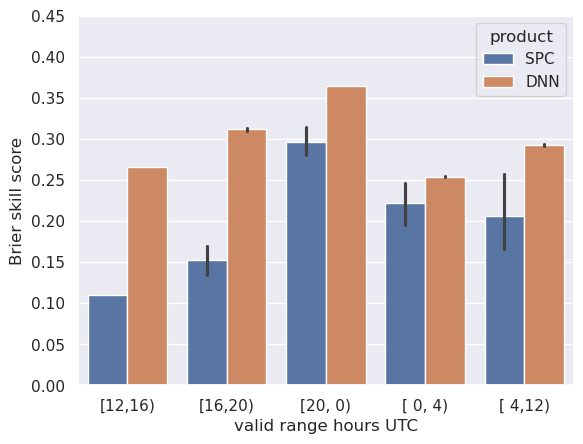

In [37]:
d = pd.concat([spc, dnn], axis=0, keys=products, names=["product", "issuance"])
d = d.reset_index().melt(
    id_vars=["product", "issuance"],
    var_name=valid_hr_str,
    value_name="Brier skill score",
)

g = sns.barplot(d, x=valid_hr_str, y="Brier skill score", hue="product")
g.set_ylim(0.0, 0.45)
ofile = tmpdir / "barplot.png"
plt.savefig(ofile)
print(ofile)

2024-02-09 13:39:00,722 /glade/derecho/scratch/ahijevyc/tmp/cg.ic.relplot.png


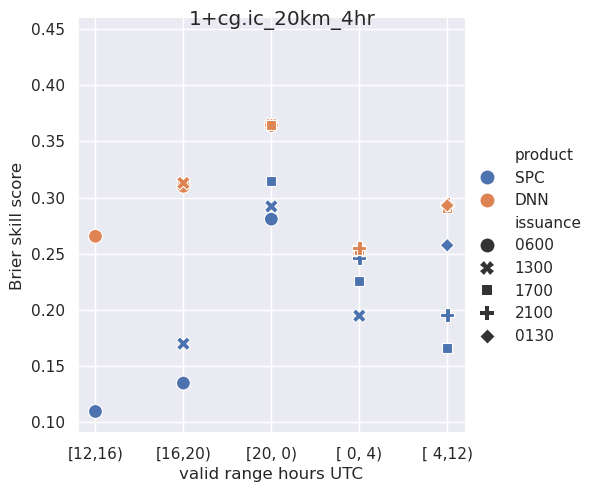

In [38]:
g = sns.relplot(
    d,
    x=valid_hr_str,
    y="Brier skill score",
    hue="product",
    style="issuance",
    kind="scatter",
    s=100,
)
plt.suptitle(f"{o_thresh}+{f}")
g.set(ylim=(0.09, 0.46))
ofile = tmpdir / f"{obsvar}.relplot.png"
g.savefig(ofile)
logging.warning(ofile)

2024-02-09 13:39:32,621 /glade/derecho/scratch/ahijevyc/tmp/cg.ic_20km_4hr.heatmap.png


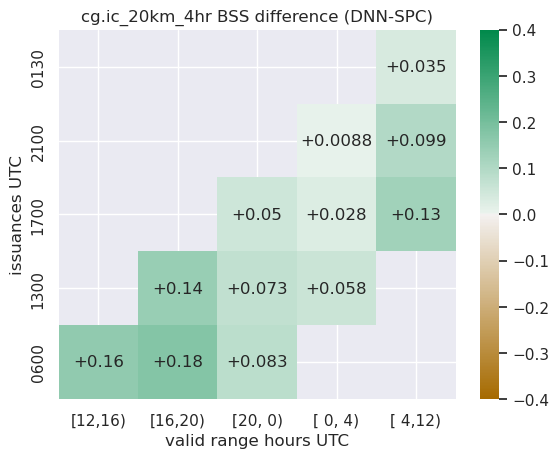

In [39]:
g = sns.heatmap(
    dnn - spc,
    annot=True,
    vmin=-0.4,
    vmax=0.4,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
    fmt="+.2",
)
g.set_title(f"{f} BSS difference (DNN-SPC)")
g.invert_yaxis()
ofile = tmpdir / f"{f}.heatmap.png"
plt.savefig(ofile)
logging.warning(ofile)

(1, 448.18499338100065)

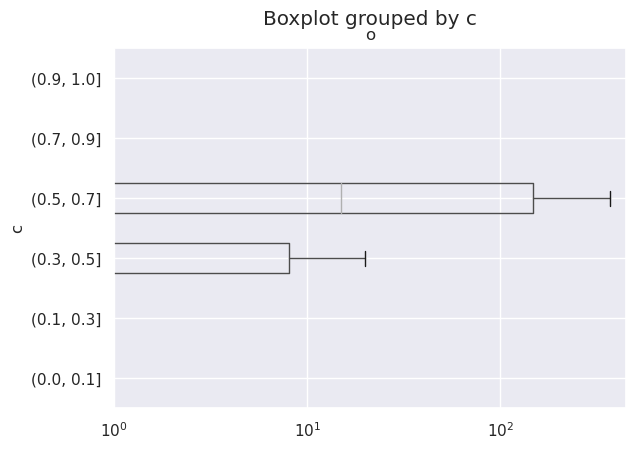

In [29]:
sample = pd.DataFrame(dict(f=fcst, o=obs))
sample["c"] = pd.cut(sample.f, [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
ax = sample.boxplot(column="o", by="c", vert=False, showfliers=False)
ax.set_xscale("log")
ax.set_xlim(left=1)